# Analysis of an object falling along an incline

Measurements of the position of a cart sliding along a rail has been measured using an ultrasonic sensor with Arduino. The corresponding file contains times and positions in two different columns. The angle made by the inline with respect to the horizontal is $17.2^\circ$. First of all we read the file and extract the data from it. The file has no header, then we use column indices to address them. The separator can be different from a comma: in that case we need to specify the delimiter.

In [14]:
import pandas as pd
import numpy as np

data = pd.read_csv('trainFalling.17.2', header = None, delimiter = ' ')
print(data)

               0      1
0   1.248268e+09  71.41
1   1.248328e+09  71.40
2   1.248388e+09  71.00
3   1.248447e+09  70.04
4   1.248507e+09  68.55
5   1.248566e+09  66.27
6   1.248625e+09  63.04
7   1.248684e+09  60.13
8   1.248742e+09  56.32
9   1.248800e+09  51.96
10  1.248857e+09  47.16
11  1.248914e+09  41.98
12  1.248970e+09  36.22
13  1.249025e+09  30.17
14  1.249079e+09  24.25
15  1.249133e+09  16.96
16  1.249186e+09   9.45
17  1.249239e+09   6.69


In [15]:
t = data[0].tolist()
x = data[1].tolist()
tx = [t*1e-6 for t in t]

Let's first make a plot of $x$ as a function of $t$

Text(0, 0.5, 'd [cm]')

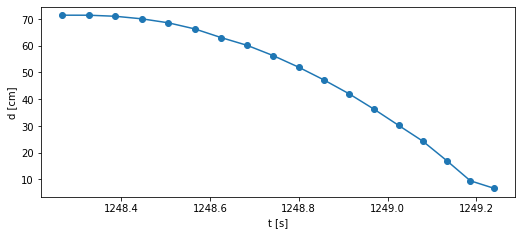

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize = (8.5, 3.5))
plt.plot(tx, x, '-o')
plt.xlabel('t [s]')
plt.ylabel('d [cm]')

The last point is too close to the sensor and must be discarded.

Text(0, 0.5, 'd [cm]')

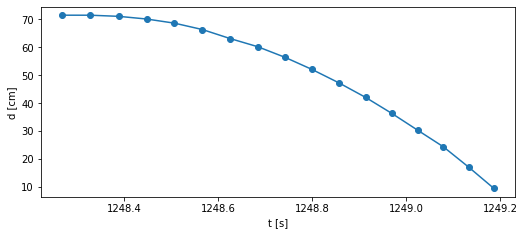

In [17]:
x.pop()
tx.pop()

plt.figure(figsize = (8.5, 3.5))
plt.plot(tx, x, '-o')
plt.xlabel('t [s]')
plt.ylabel('d [cm]')

Translates the origin and compute v and a

In [18]:
t0 = tx[0]
x0 = x[-1]
for i in range(len(x)):
    tx[i] -= t0
    x[i] -= x0

v = []
a = []
for i in range(len(x) - 1):    
    v.append((x[i+1]-x[i])/(tx[i+1]-tx[i])/100.)

for i in range(len(x) - 2):
    a.append((v[i+1]-v[i])/(tx[i+1]-tx[i]))
    
t = tx.copy()
t.pop()

ta = t.copy()
ta.pop()

0.8652799999999843

Make plots of v vs t and a vs t

Text(0, 0.5, 'a [m/s$^2$]')

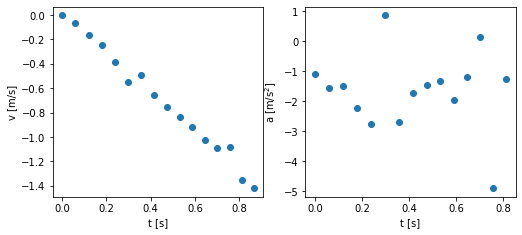

In [19]:
fig = plt.figure(figsize = (8.3, 3.5))
avt = fig.add_subplot(1,2,1)
aat = fig.add_subplot(1,2,2)
avt.plot(t, v, 'o')
avt.set_xlabel('t [s]')
avt.set_ylabel('v [m/s]')
aat.plot(ta, a, 'o')
aat.set_xlabel('t [s]')
aat.set_ylabel('a [m/s$^2$]')

Data seems compatible with a = const. Evaluate it

In [20]:
print('========= acceleration ===========')
stdeva = np.std(a)
stdevv = np.std(v)
print('average(a) = {:.2f} stdev(a) = {:.2f} stdev(a)/sqrt(N) = {:.2f}'.format(np.average(a), 
                                                                   stdeva, 
                                                                   stdeva/np.sqrt(len(a))))

========= acceleration ===========
average(a) = -1.65 stdev(a) = 1.26 stdev(a)/sqrt(N) = 0.32


To fit the distribution of v vs t we need to define the fitting function, then minimise the chisquare. We also define a function that returns the value of the chisquare.

In [21]:
from scipy.optimize import curve_fit

def linear(x, A, B):
    return A*x+B

def chisquare(x, y, fun, par, sigma = None):
    chi2 = 0.
    for i in range(len(x)):
        s = 1
        if sigma:
            s = sigma[i]
        chi2 += ((y[i]-fun(x[i], par[0], par[1]))/s)**2
    return chi2

print('======== v fit results ============')
res, cov = curve_fit(linear, t, v)

print('alpha = {:.2f} +- {:.2f}'.format(res[0], np.sqrt(cov[0][0])))
print('beta  = {:.2f} +- {:.2f}'.format(res[1], np.sqrt(cov[1][1])))

chi2 = chisquare(y=v, x=t, fun=linear, par=res)
ndf = len(t)-len(res)
print('chiSquare    : {:.3f}/{} NDF'.format(chi2, ndf))
print('chiSquare/NDF: {:.3f}'.format(chi2/ndf))

from scipy import stats

print('p-value.     : {}'.format(1-stats.chi2.cdf(chi2, ndf)))

======== v fit results ============
alpha = -1.61 +- 0.05
beta  = 0.02 +- 0.02
chiSquare    : 0.032/14 NDF
chiSquare/NDF: 0.002
p-value.     : 0.9999999999999999


The p-value is practically 1, but it does not make sense since we performed an unweighted fit. To make a properly weighted fit we need to weight each term in the sum by its uncertainty. We take the relative uncertainty on $v$ as 10%, while that of $a$ of 20%.

In [22]:
wv = [0.1*np.average(v)]*len(v)
wa = [0.2*np.average(a)]*len(a)

In [23]:
print('======== v weighted fit results ============')
fitres, cov = curve_fit(linear, t, v, sigma=wv, absolute_sigma=True)
print('** alpha = {:.2f} +- {:.2f}'.format(fitres[0], np.sqrt(cov[0][0])))
print('** beta  = {:.2f} +- {:.2f}'.format(fitres[1], np.sqrt(cov[1][1])))
chi2 = chisquare(t, v, par = fitres, fun = linear, sigma = wv)
ndf = len(t)-len(fitres)
print('** chiSquare    : {:.2f}/{} NDF'.format(chi2, ndf))
print('** chiSquare/NDF: {:.2f}'.format(chi2/ndf))
print('** p-value      : {}'.format(1-stats.chi2.cdf(chi2, ndf)))

======== v weighted fit results ============
** alpha = -1.61 +- 0.06
** beta  = 0.02 +- 0.03
** chiSquare    : 6.80/14 NDF
** chiSquare/NDF: 0.49
** p-value      : 0.9420535872456881


Let's check the hypothesis about a=const. To reuse the same chisquare function, a constant is represented as ``0*x+res[0]``

In [136]:
def constant(x, A):
    return A

print('======== a weighted fit results ============')
ares, cov = curve_fit(constant, ta, a, sigma=wa, absolute_sigma=True)
print('** a = {:.2f} +- {:.2f}'.format(ares[0], np.sqrt(cov[0][0])))
pp = [0, ares[0]]
chi2 = chisquare(ta, a, linear, pp, wa)
ndf = len(t)-len(ares)
print('** chiSquare    : {:.2f}/{} NDF'.format(chi2, ndf))
print('** chiSquare/NDF: {:.2f}'.format(chi2/ndf))
print('** p-value      : {}'.format(1-stats.chi2.cdf(chi2, ndf)))

** a = -1.65 +- 0.08
** chiSquare    : 219.14/15 NDF
** chiSquare/NDF: 14.61
** p-value      : 0.0


As an alternative, a linear model can be tested

In [137]:
print('======== a weighted fit (linear) results ============')
res, cov = curve_fit(linear, ta, a, sigma=wa, absolute_sigma=True)
print(res)
chi2 = chisquare(ta, a, linear, res, wa)
ndf = len(t)-len(res)
print('** chiSquare    : {:.2f}/{} NDF'.format(chi2, ndf))
print('** chiSquare/NDF: {:.2f}'.format(chi2/ndf))
print('** p-value      : {}'.format(1-stats.chi2.cdf(chi2, ndf)))

[-0.57569259 -1.40842325]
** chiSquare    : 216.25/14 NDF
** chiSquare/NDF: 15.45
** p-value      : 0.0


Text(0, 0.5, 'a [m/s$^2$]')

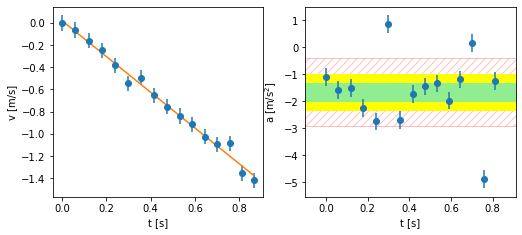

In [155]:
fig = plt.figure(figsize = (8.3, 3.5))
avt = fig.add_subplot(1,2,1)
aat = fig.add_subplot(1,2,2)
avt.errorbar(t, v, yerr = wv, fmt = 'o')

p2 = np.poly1d(fitres)

avt.plot(t, p2(t), '-')
avt.set_xlabel('t [s]')
avt.set_ylabel('v [m/s]')

ares, cov = curve_fit(constant, ta, a, sigma=wa)
sigma_a = np.sqrt(cov[0][0])
p2 = np.poly1d(ares)

tt = [ta[0]-0.1, ta[-1]+0.1]
aat.fill_between(tt, p2(tt)-stdeva, p2(tt)+stdeva, alpha=.25, hatch='///', edgecolor='red', facecolor='white')
aat.fill_between(tt, p2(tt)-2*sigma_a, p2(tt)+2*sigma_a, color = 'yellow')
aat.fill_between(tt, p2(tt)-sigma_a, p2(tt)+sigma_a, color = 'lightgreen')
aat.errorbar(ta, a, yerr = wa, fmt = 'o')
aat.set_xlim(tt[0], tt[-1])
aat.set_xlabel('t [s]')
aat.set_ylabel('a [m/s$^2$]')